In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas_ml_quant_data_provider as dp
from pandas_ml_quant import pd, np

automatically imported pandas_ml_quant_data_provider 0.2.0


In [2]:
df = dp.fetch("DIA IWM GLD ^TNX".split(" "))
df.tail()


DIA                                                            \
              Open    High     Low   Close     Volume Dividends Stock Splits   
Date                                                                           
2020-11-24  298.94  301.11  298.30  300.43  4022700.0       0.0          0.0   
2020-11-25  299.95  300.04  298.05  298.74  2629200.0       0.0          0.0   
2020-11-30  297.52  297.80  294.75  296.62  4159300.0       0.0          0.0   
2020-12-01  299.73  301.01  298.18  298.44  2865700.0       0.0          0.0   
2020-12-02  297.10  299.34  296.35  299.18  2451474.0       0.0          0.0   

               IWM                  ...         GLD                         \
              Open    High     Low  ...      Volume Dividends Stock Splits   
Date                                ...                                      
2020-11-24  183.39  185.44  182.36  ...  19504000.0       0.0          0.0   
2020-11-25  183.50  184.31  181.89  ...  10286600.0       0.0          0.0   
2020-11-30  183.82  184.32  180.32  ...  13210000.0       0.0          0.0   
2020-12-01  183.60  184.22  181.02  ...  13555200.0       0.0          0.0   
2020-12-02  181.95  183.48  180.76  ...   9199741.0       0.0          0.0   

             ^TNX                                                     
             Open   High    Low  Close Volume Dividends Stock Splits  
Date                                                                  
2020-11-24  0.873  0.888  0.865  0.882    0.0       0.0          0.0  
2020-11-25  0.880  0.885  0.855  0.878    0.0       0.0          0.0  
2020-11-30  0.850  0.859  0.837  0.844    0.0       0.0          0.0  
2020-12-01  0.857  0.938  0.857  0.934    0.0       0.0          0.0  
2020-12-02  0.923  0.966  0.920  0.948    0.0       0.0          0.0  

[5 rows x 28 columns]

In [3]:
returns = df._["Close"].pct_change()
returns.tail()

Close                              
                 DIA       IWM       GLD      ^TNX
Date                                              
2020-11-24  0.015344  0.018803 -0.015328  0.029172
2020-11-25 -0.005625 -0.003420 -0.000472 -0.004535
2020-11-30 -0.007096 -0.013999 -0.016754 -0.038724
2020-12-01  0.006136  0.009281  0.021060  0.106635
2020-12-02  0.002480  0.001314  0.007933  0.014989

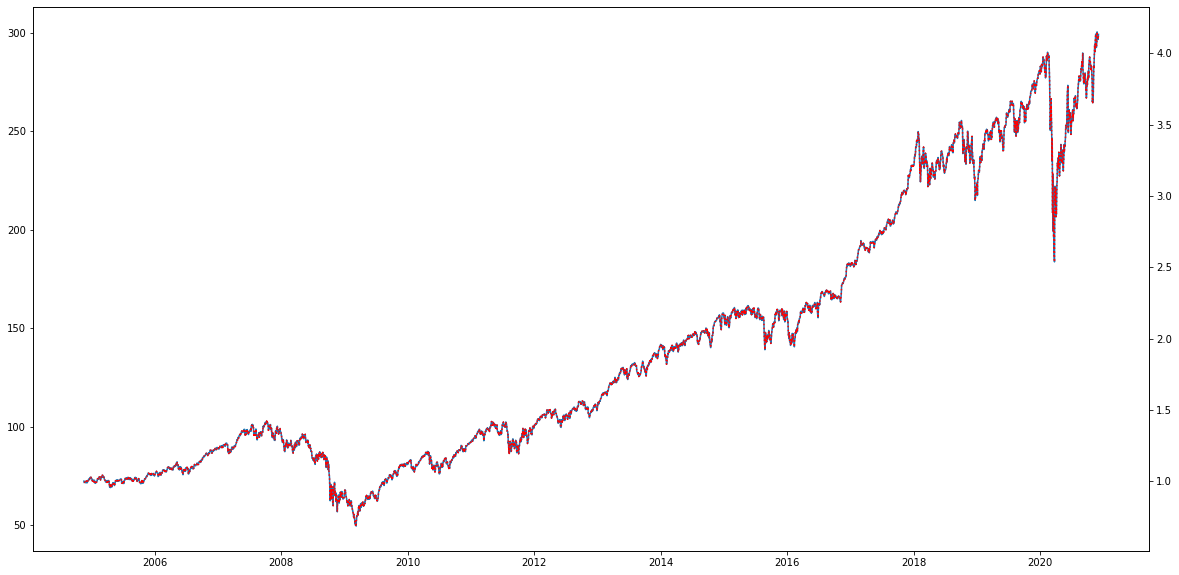

In [11]:
# example of reconstruction of returns
f, a = plt.subplots(1, 1, figsize=(20, 10))
a2 = a.twinx()  # instantiate a second axes that shares the same x-axis

a.plot(df.index, df["DIA", "Close"].values)
a2.plot(df.index, (1 + df["DIA", "Close"].pct_change()).cumprod(), color='red', linestyle=':')

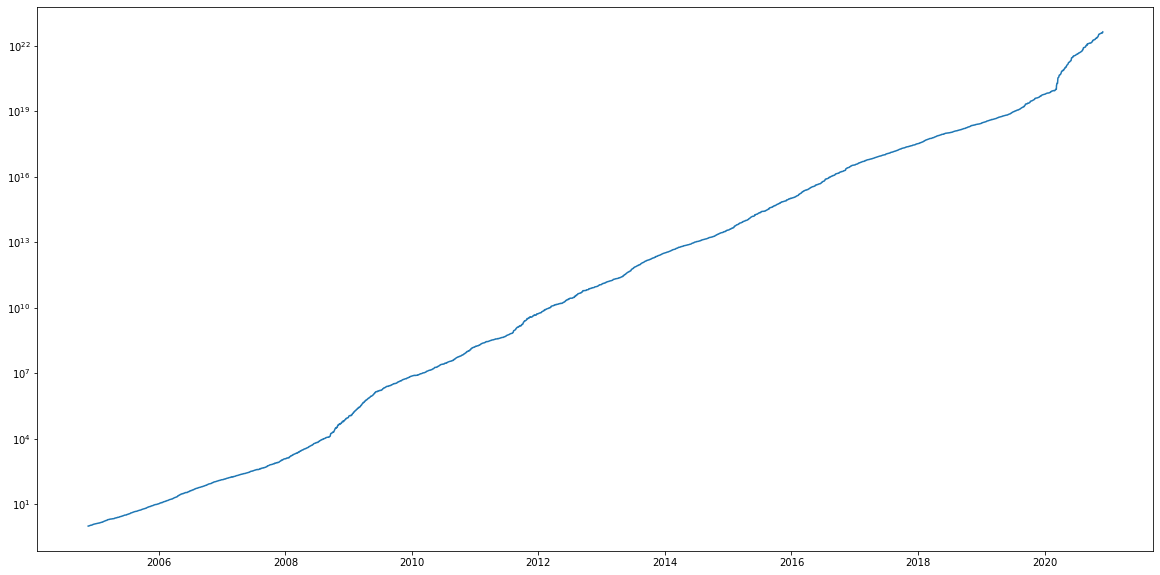

In [4]:
# very hypothetical maximum possible return portfolio
max_return = returns.max(axis=1)
max_possible_portfolio = (1 + max_return.dropna()).cumprod()

f, a = plt.subplots(1, 1, figsize=(20, 10))
a.plot(max_possible_portfolio.index, max_possible_portfolio.values)
a.set_yscale('log')

In [44]:
# naive optimized portfolio
with df.model() as m:
    from pandas_ml_quant.model.rolling.minimum_variance import MarkowitzModel

    mm = MarkowitzModel(
        price_column = 'Close',
        risk_aversion = 0.5,
    )
    fit = m.fit(**mm.to_fitter_kwargs())

fit.test_summary

/home/kic/sources/private/projects/pandas-quant/pandas-ml-utils/pandas_ml_utils/ml/model/base_model.py:116: RuntimeWarning: Mean of empty slice.
  test_loss = np.array([self.calculate_loss(fold, x, y, w) for x, y, w in test_data if len(x) > 0]).mean()
/home/kic/sources/private/projects/pandas-quant/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Portfolio,1/N
Performance (%),-57.539,159.248
CVaR95 (%),-4.148,-2.647
Sharpe,-0.000,0.001
Days,3976,3976
Last Day,2020-11-30 00:00:00,2020-11-30 00:00:00
# trades,3976,3976
trade_ratio,1.000,1.000


In [45]:
# use a momentum based return estimator
with df.model() as m:
    from pandas_ml_quant.model.rolling.minimum_variance import MarkowitzModel

    mm = MarkowitzModel(
        price_column = 'Close',
        risk_aversion = 0.5,
        returns_estimator = lambda df: (df._["Close"].ta.div(lambda a: a.ta.sma(10), lambda b: b.ta.sma(30)) - 1).droplevel(0, axis=1)
    )
    fit = m.fit(**mm.to_fitter_kwargs())

fit.test_summary

/home/kic/sources/private/projects/pandas-quant/pandas-ml-utils/pandas_ml_utils/ml/model/base_model.py:116: RuntimeWarning: Mean of empty slice.
  test_loss = np.array([self.calculate_loss(fold, x, y, w) for x, y, w in test_data if len(x) > 0]).mean()
/home/kic/sources/private/projects/pandas-quant/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Portfolio,1/N
Performance (%),70.757,165.930
CVaR95 (%),-4.526,-2.647
Sharpe,0.001,0.001
Days,3967,3967
Last Day,2020-11-30 00:00:00,2020-11-30 00:00:00
# trades,3967,3967
trade_ratio,1.000,1.000


In [7]:
# use an arima based return estimator
with df.model() as m:
    from pandas_ml_quant.model.rolling.minimum_variance import MarkowitzModel

    mm = MarkowitzModel(
        price_column = 'Close',
        risk_aversion = 0.5,
        returns_estimator = lambda df: df._["Close"].ta.ema(2).pct_change().ta.sarimax()
    )
    fit = m.fit(**mm.to_fitter_kwargs())

fit.test_summary



/home/kic/sources/private/projects/pandas-quant/.venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/kic/sources/private/projects/pandas-quant/.venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kic/sources/private/projects/pandas-quant/pandas-ml-utils/pandas_ml_utils/ml/model/base_model.py:116: RuntimeWarning: Mean of empty slice.
  test_loss = np.array([self.calculate_loss(fold, x, y, w) for x, y, w in test_data if len(x) > 0]).mean()
/home/kic/sources/private/projects/pandas-quant/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dty

,Portfolio,1/N
Performance (%),9.614,174.318
CVaR95 (%),-4.093,-2.657
Sharpe,0.000,0.001
Days,3938,3938
Last Day,2020-12-02 00:00:00,2020-12-02 00:00:00
# trades,3938,3938
trade_ratio,1.000,1.000
